In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Introduction
This task is a binary image classification problem where you will identify metastatic cancer in small image patches taken from larger digital pathology scans.There are 96x96 pixels in each image,and the image has 3 channels.There are 220025 images in the training set.  
We are going to use deeplearning techques to identify metastatic cancer. 

There are 4 steps to complete this task.

1. Exploratory Data Analysis (EDA)
2. Building and training models
3. Results and Analysis

First,import the librays we need


In [2]:
# visualize the data
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as px
import matplotlib.patches as patches

from skimage import io

# build model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPooling2D,Flatten,Dropout,AveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2022-09-28 09:48:49.174368: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# load the data
# train_dir = '../input/histopathologic-cancer-detection/train/'
# test_dir = '../input/histopathologic-cancer-detection/test/'
# train_labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

train_dir = './train/'
test_dir = './test/'

train_labels = pd.read_csv('./train_labels.csv')


### 1、Exploratory Data Analysis (EDA)


The first column of the train_labels is the ids of the trianing images.

In [4]:
# let's see the train_labels and the shape of train_labels

print('train_labels\n',train_labels.head())

print('train_labels.shape\n',train_labels.shape)


train_labels
                                          id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
train_labels.shape
 (220025, 2)


let's append .tif to the columns of id

In [5]:
def append_tif(fn):
    return str(fn+'.tif')

train_labels['id'] = train_labels['id'].apply(append_tif)
train_labels['label'] = train_labels['label'].astype(str)
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


Let's plot some images of the training set

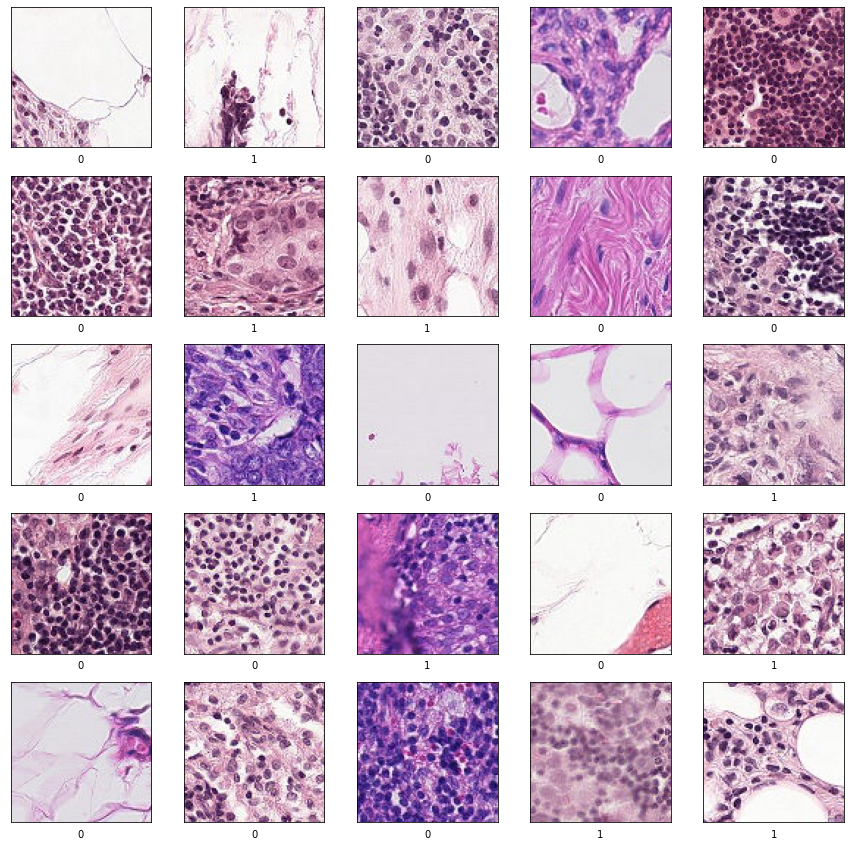

In [6]:
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i, axis in enumerate(ax.flat):
    path = str(train_dir + train_labels['id'][i])
    image = io.imread(path)
    axis.imshow(image)
    axis.set(xticks=[], yticks=[], xlabel = train_labels.label[i]);

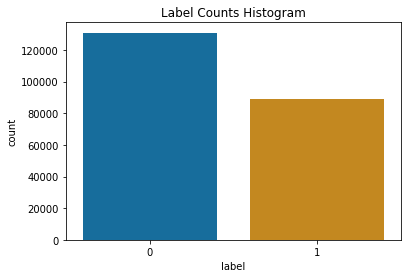

In [7]:
# let's see the histogram of the training data
sns.countplot(x=train_labels['label'], palette='colorblind').set(title='Label Counts Histogram');

Split the train_labels into train set and validation set

In [30]:
# split the data into train and validation set
train_data,test_labels = train_test_split(train_labels,test_size=0.2,random_state=18)

print("train_data.shape\n",train_data.shape)
print("test_data.shape\n",test_data.shape)

train_data.shape
 (176020, 2)
test_data.shape
 (57458, 1)


Normalize the data and generate the train and validation set

In [31]:
# All images will rescaled by 1/255.0
BATCH = 256
datagen = ImageDataGenerator(rescale=1/255.0,validation_split=0.2)

train_generator = datagen.flow_from_dataframe(dataframe=train_data,
                                                    directory=train_dir,
                                                    x_col="id",
                                                    y_col="label",
                                                    batch_size=BATCH,
                                                    subset='training',
                                                    target_size=(96,96),
                                                    class_mode='binary')
val_generator = datagen.flow_from_dataframe(dataframe=train_data,
                                                    directory=train_dir,
                                                    x_col="id",
                                                    y_col="label",
                                                    batch_size=BATCH,
                                                    subset='validation',
                                                    target_size=(96,96),
                                                    class_mode='binary')


Found 140816 validated image filenames belonging to 2 classes.
Found 35204 validated image filenames belonging to 2 classes.


In [51]:
test_labels

,id,label
195045,906bdaa713e5b1b7f62662218c9afd571cdcd3e6.tif,0
47060,5a48858b4fa473fd8f2230a85c21baae2294d1f2.tif,1
108667,9b7076597f89dc858f4dff72994dd28a67b0607b.tif,0
93080,698c8786b50e05b0ce755a7b47894a3cf5dde10b.tif,0
142277,80e5621658bd0596f488e22f7a7585a3dc2d2df5.tif,0
...,...,...
60335,023c47d8d0e123c75159dc9fa69e46dea8f11845.tif,1
1786,8db4de88b8e1515b6d8bd82f94154721bc85b35b.tif,1
145439,87ace428e4e25216625c32b3fdff511f0f694263.tif,0
75116,cfbc0695b07b9d4012ecb3502e19a478118c72bf.tif,0


In [47]:
x_test = test_labels.drop(columns=['label'])
x_test

,id
195045,906bdaa713e5b1b7f62662218c9afd571cdcd3e6.tif
47060,5a48858b4fa473fd8f2230a85c21baae2294d1f2.tif
108667,9b7076597f89dc858f4dff72994dd28a67b0607b.tif
93080,698c8786b50e05b0ce755a7b47894a3cf5dde10b.tif
142277,80e5621658bd0596f488e22f7a7585a3dc2d2df5.tif
...,...
60335,023c47d8d0e123c75159dc9fa69e46dea8f11845.tif
1786,8db4de88b8e1515b6d8bd82f94154721bc85b35b.tif
145439,87ace428e4e25216625c32b3fdff511f0f694263.tif
75116,cfbc0695b07b9d4012ecb3502e19a478118c72bf.tif


In [48]:
y_true = test_labels['label'].values
y_true

array(['0', '1', '0', ..., '0', '0', '0'], dtype=object)

In [52]:
test_datagen = ImageDataGenerator(rescale=1/255.0)

test_generator = test_datagen.flow_from_dataframe(dataframe=test_labels,
                                                    directory=train_dir,
                                                    x_col="id",
                                                    y_col="label",
                                                    batch_size=BATCH,
                                                    target_size=(96,96),
                                                    class_mode='binary')

Found 44005 validated image filenames belonging to 2 classes.


In [53]:
model.evaluate(test_generator)

172/172 [==============================] - 309s 2s/step - loss: 0.3701 - accuracy: 0.8422


[0.37011411786079407, 0.8421770334243774]

### 2、Building and training models

First,design our deeplearning model architeure. As the image is full color,so each image has 3 channels.And there are binary classification,so we have a single neuron in the output layer using sigmoid activation function.   
- The input shape is 96x96x3
- The first convolution layers with 32 filters 
- Then 2 conovolution layers with 64 filters 
- Then 2 convolution layer with 32 filters
- Each layers with kernel 3x3 then connect to a maxpooling layer with kernel 2x2 
- The ouput layer is a Dense layer with 1 neurons and activation is sigmoid, the ouput layer is to predict
the probability the of the input image
- Using Dropout at each layer

In [11]:
# create the model
    
model = Sequential([
    Input((96,96,3)),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.1),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.1),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.1),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.1),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(units=1,activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 47, 47, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 22, 22, 64)        0

2022-09-28 09:49:57.820155: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 10, 10, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 32)          18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 4, 4, 32)          0         
                                                                 
 conv2d_4 (Conv2D)           (None, 2, 2, 32)          9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 1, 1, 32)         0         
 2D)                                                             
          

In [12]:
# config loss and opitimizer,we use Adam with learning_rate 0.001
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])

In [13]:
history = model.fit(train_generator,epochs=5,validation_data=val_generator)

Epoch 1/5
551/551 [==============================] - 1385s 3s/step - loss: 0.4728 - accuracy: 0.7780 - val_loss: 0.4318 - val_accuracy: 0.8101
Epoch 2/5
551/551 [==============================] - 1374s 2s/step - loss: 0.4062 - accuracy: 0.8201 - val_loss: 0.3802 - val_accuracy: 0.8400
Epoch 3/5
551/551 [==============================] - 1372s 2s/step - loss: 0.3588 - accuracy: 0.8454 - val_loss: 0.3684 - val_accuracy: 0.8430
Epoch 4/5
551/551 [==============================] - 1366s 2s/step - loss: 0.3140 - accuracy: 0.8677 - val_loss: 0.2788 - val_accuracy: 0.8850
Epoch 5/5
551/551 [==============================] - 1372s 2s/step - loss: 0.2866 - accuracy: 0.8818 - val_loss: 0.2594 - val_accuracy: 0.8955


Plot loss and accuracy per epoch

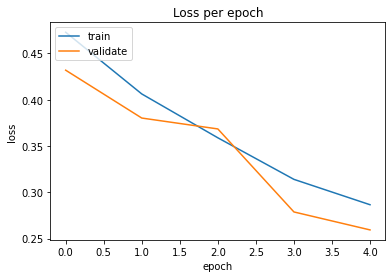

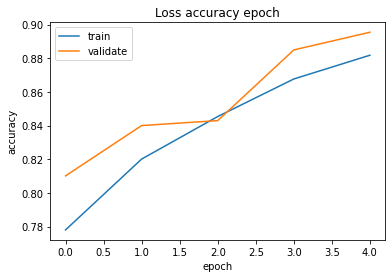

In [14]:
# plot loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

# plot accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Loss accuracy epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

Let's perform the test data

In [54]:
test_data = pd.DataFrame({'id':os.listdir(test_dir)})
test_data.head()

,id
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d.tif
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581.tif
2,19709bec800f372d0b1d085da6933dd3ef108846.tif
3,7a34fc34523063f13f0617f7518a0330f6187bd3.tif
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed.tif


In [55]:
test_datagen = ImageDataGenerator(rescale=1/255.0)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_data,
                                                    directory=test_dir,
                                                    x_col="id",
                                                    y_col=None,
                                                    batch_size=BATCH,
                                                    target_size=(96,96),
                                                    class_mode=None)

Found 57458 validated image filenames.


In [56]:
test_data

,id
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d.tif
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581.tif
2,19709bec800f372d0b1d085da6933dd3ef108846.tif
3,7a34fc34523063f13f0617f7518a0330f6187bd3.tif
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed.tif
...,...
57453,2581931c6ef068f105a872f2c5500275fc678242.tif
57454,11b250a664d09ab59fd2afbdb2f8d786763b185d.tif
57455,18a6030935ec1ef1ce486ec51bc95abb4008fbf1.tif
57456,f541404e501e23a0188c852eb37eac94053cfdc0.tif


Predict on the test data

In [57]:
y_pred = model.predict(test_generator)

# y_pred = np.where(y_pred>0.5,1,0)


225/225 [==============================] - 331s 1s/step


In [58]:
# see the first five predict datas
y_pred[:5]

array([[0.6460926 ],
       [0.15193489],
       [0.73818076],
       [0.4103524 ],
       [0.12084156]], dtype=float32)

In [62]:
np.squeeze(y_pred)

array([0.6460926 , 0.15193489, 0.73818076, ..., 0.19925198, 0.44610468,
       0.67748046], dtype=float32)

In [65]:
np.where(np.squeeze(y_pred)>0.5,1,0)

array([1, 0, 1, ..., 0, 0, 1])

In [63]:
np.transpose(y_pred)[0]

array([0.6460926 , 0.15193489, 0.73818076, ..., 0.19925198, 0.44610468,
       0.67748046], dtype=float32)

In [66]:
y_pred = np.transpose(y_pred)[0]
submission_df = pd.DataFrame()
submission_df['id'] = test_data['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, y_pred))
submission_df.head()

,id,label
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d,1
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581,0
2,19709bec800f372d0b1d085da6933dd3ef108846,1
3,7a34fc34523063f13f0617f7518a0330f6187bd3,0
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed,0


Save to the submission file

In [67]:
submission_df.to_csv('submission.csv', index=False)

As we submit this file to kaggle we got 0.5 accuracy. we think our model is overfiting so we tune our model architecture.

#### Compare to another architeure

In [21]:
model = Sequential([
    Input((96,96,3)),
    Conv2D(32,(3,3),activation='relu'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.1),
    Conv2D(64,(3,3),activation='relu'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.1),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.1),
    Conv2D(16,(3,3),activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(units=1,activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 conv2d_6 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 46, 46, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 46, 46, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 conv2d_8 (Conv2D)           (None, 42, 42, 64)        36928     
                                                      

In [22]:
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])

In [23]:
history = model.fit(train_generator,epochs=2,validation_data=val_generator)

Epoch 1/2
551/551 [==============================] - 3346s 6s/step - loss: 0.4926 - accuracy: 0.7648 - val_loss: 0.4545 - val_accuracy: 0.7885
Epoch 2/2
551/551 [==============================] - 3272s 6s/step - loss: 0.4074 - accuracy: 0.8206 - val_loss: 0.3709 - val_accuracy: 0.8413


In [24]:
# predict 
y_pred = model.predict(test_generator)
y_pred[:5]

225/225 [==============================] - 301s 1s/step


array([[0.14319602],
       [0.07494285],
       [0.9842303 ],
       [0.11031973],
       [0.06754917]], dtype=float32)

In [25]:
# submission file
y_pred = np.transpose(y_pred)[0]
submission_df = pd.DataFrame()
submission_df['id'] = test_data['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, y_pred))
submission_df

,id,label
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d,0
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581,0
2,19709bec800f372d0b1d085da6933dd3ef108846,1
3,7a34fc34523063f13f0617f7518a0330f6187bd3,0
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed,0
...,...,...
57453,2581931c6ef068f105a872f2c5500275fc678242,1
57454,11b250a664d09ab59fd2afbdb2f8d786763b185d,1
57455,18a6030935ec1ef1ce486ec51bc95abb4008fbf1,0
57456,f541404e501e23a0188c852eb37eac94053cfdc0,1


In [26]:
submission_df.to_csv('submission.csv', index=False)

We submit this file again,and we got the similar score, about 0.5! I am confused.

### 3、Result and Analysis

The first model we use 5 convolution layers and 1 dense to build the model to classify the task. We got the training accuracy 0.8818 and the validation accuracy about 0.8955. It seem predict good in this model then submit the predict to kaggle,but we got about 0.5 score! I dont get it.

Since the task is taking so much time to run,we did not perform many tuning techques.  

For example, We use fixed learning_rate 0.001 and adam optimizer to the model. We think the learning_rate can be tune using decay techques to find the best value instead of using the fixed learning_rate all the time.   



### 4、Conclustions

We use 2 different architetures to learn a model, we using convolution layers , dropout to regularization , we also tune the learning rate, we using learning rate 0.01 at first but got more accuracy when we tune the learning rate to 0.001.
Each model seems fit the training data pretty good and do well on the validation data. But bad performance at the test data. 